# Predicting Diagnostic on Breast Cancer

This project is about predicting diagnosis on breast cancer with given 30 features. The dataset is from UCI repository. The dataset and its associated description can be found here. https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [31]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import joblib

Load the dataset and check its shape.

In [32]:
cancer = pd.read_csv('data.csv')
print(cancer.shape)
cancer.head(2)

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


In [33]:
cancer.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

Cancel the meaningless columns and put the target column to the end of dataframe

In [34]:
diag = cancer['diagnosis']
cancer.drop(['id', 'diagnosis', 'Unnamed: 32'], axis = 1, inplace = True)
cancer = cancer.join(diag)

In [35]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(cancer)

radius_mean 
 [ 6.981  7.691  7.729  7.76   8.196  8.219  8.571  8.597  8.598  8.618
  8.671  8.726  8.734  8.878  8.888  8.95   9.     9.029  9.042  9.173
  9.268  9.295  9.333  9.397  9.405  9.423  9.436  9.465  9.504  9.567
  9.606  9.667  9.668  9.676  9.683  9.72   9.731  9.738  9.742  9.755
  9.777  9.787  9.847  9.876  9.904 10.03  10.05  10.08  10.16  10.17
 10.18  10.2   10.25  10.26  10.29  10.32  10.44  10.48  10.49  10.51
 10.57  10.6   10.65  10.66  10.71  10.75  10.8   10.82  10.86  10.88
 10.9   10.91  10.94  10.95  10.96  10.97  11.04  11.06  11.08  11.13
 11.14  11.15  11.16  11.2   11.22  11.25  11.26  11.27  11.28  11.29
 11.3   11.31  11.32  11.33  11.34  11.36  11.37  11.41  11.42  11.43
 11.45  11.46  11.47  11.49  11.5   11.51  11.52  11.54  11.57  11.6
 11.61  11.62  11.63  11.64  11.66  11.67  11.68  11.69  11.7   11.71
 11.74  11.75  11.76  11.8   11.81  11.84  11.85  11.87  11.89  11.9
 11.93  11.94  11.95  11.99  12.    12.03  12.04  12.05  12.06  12.07
 12.

smoothness_worst 
 [0.07117 0.08125 0.08409 0.08484 0.08567 0.08774 0.08799 0.08822 0.08864
 0.08949 0.08996 0.09023 0.09203 0.09267 0.09293 0.09312 0.09329 0.09368
 0.09384 0.09387 0.09388 0.09402 0.09422 0.09439 0.09445 0.09457 0.09527
 0.09534 0.09545 0.09616 0.09701 0.09711 0.09794 0.09836 0.09861 0.09862
 0.09926 0.09958 0.0997  0.09983 0.09994 0.1001  0.1005  0.1006  0.1009
 0.1011  0.1013  0.1015  0.1016  0.1017  0.1021  0.1025  0.1026  0.1028
 0.103   0.1034  0.1036  0.1037  0.1038  0.1041  0.1045  0.1048  0.105
 0.1054  0.106   0.1064  0.1065  0.1066  0.1068  0.1072  0.1073  0.1076
 0.1077  0.1081  0.1084  0.1085  0.1086  0.1087  0.1089  0.1092  0.1094
 0.1095  0.1096  0.1097  0.1101  0.1102  0.1103  0.1104  0.1105  0.1108
 0.111   0.1111  0.1115  0.1116  0.1118  0.112   0.1121  0.1123  0.1124
 0.1126  0.1128  0.1131  0.1134  0.1135  0.1136  0.1137  0.1139  0.114
 0.1142  0.1143  0.1144  0.1147  0.1148  0.1153  0.1157  0.1162  0.1166
 0.1168  0.117   0.1171  0.1172  0.1175  0.

The data above indicates that the feature data has a type of numerical and target is binary.

In [36]:
def snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

snapshot = snapshot(cancer)
snapshot

,n_unique,dtype,n_missing,pct_missing
radius_mean,456,float64,0,0.0
texture_mean,479,float64,0,0.0
perimeter_mean,522,float64,0,0.0
area_mean,539,float64,0,0.0
smoothness_mean,474,float64,0,0.0
compactness_mean,537,float64,0,0.0
concavity_mean,537,float64,0,0.0
concave points_mean,542,float64,0,0.0
symmetry_mean,432,float64,0,0.0
fractal_dimension_mean,499,float64,0,0.0


The table above shows that there is no missing value found in the dataset. 
And the number of unique value in each feature reinforces that the data type of all features is numerical and target is binary.

In [37]:
num = cancer.columns.drop('diagnosis')

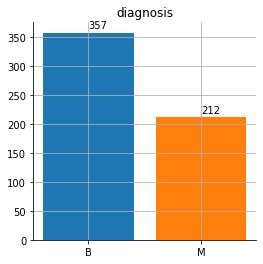

In [38]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()
    
plot_single_categorical(cancer, 'diagnosis')

The graph above shows that there are more samples with target label 'B' than samples with label 'M'. 


And the quantity ratio of 'M' samples to 'B' samples is 3:5, which demonstrates that the target is not biased.

In [39]:
def scatter_fea_corr_classif_targ(df, features, target):
    corr = df[features].corr()
    n_features = len(features)
    n_sub_figs = (n_features * n_features - n_features) / 2
    if n_sub_figs < 4:
        nrows = 1
        ncols = n_sub_figs
        fig = plt.figure(figsize = (ncols * 3.75, 3))
    else:
        nrows =  math.ceil(n_sub_figs / 4)
        ncols = 4
        fig = plt.figure(figsize = (15, nrows * 3))
    
    m = 1
    for col in features:
        col_index = features.index(col)
        i = 1
        while (col_index + i) <= (n_features - 1):
            corr_val = 0
            ax = fig.add_subplot(nrows, ncols, m)
            ax = sns.scatterplot(x = col, y = features[col_index + i], hue = target, data = df)
            corr_val = round(corr.loc[col, features[col_index + i]], 2)
            plt.title(corr_val)
            
            i += 1
            m += 1
        if col_index == 0:
            break
    plt.tight_layout()
    plt.show()

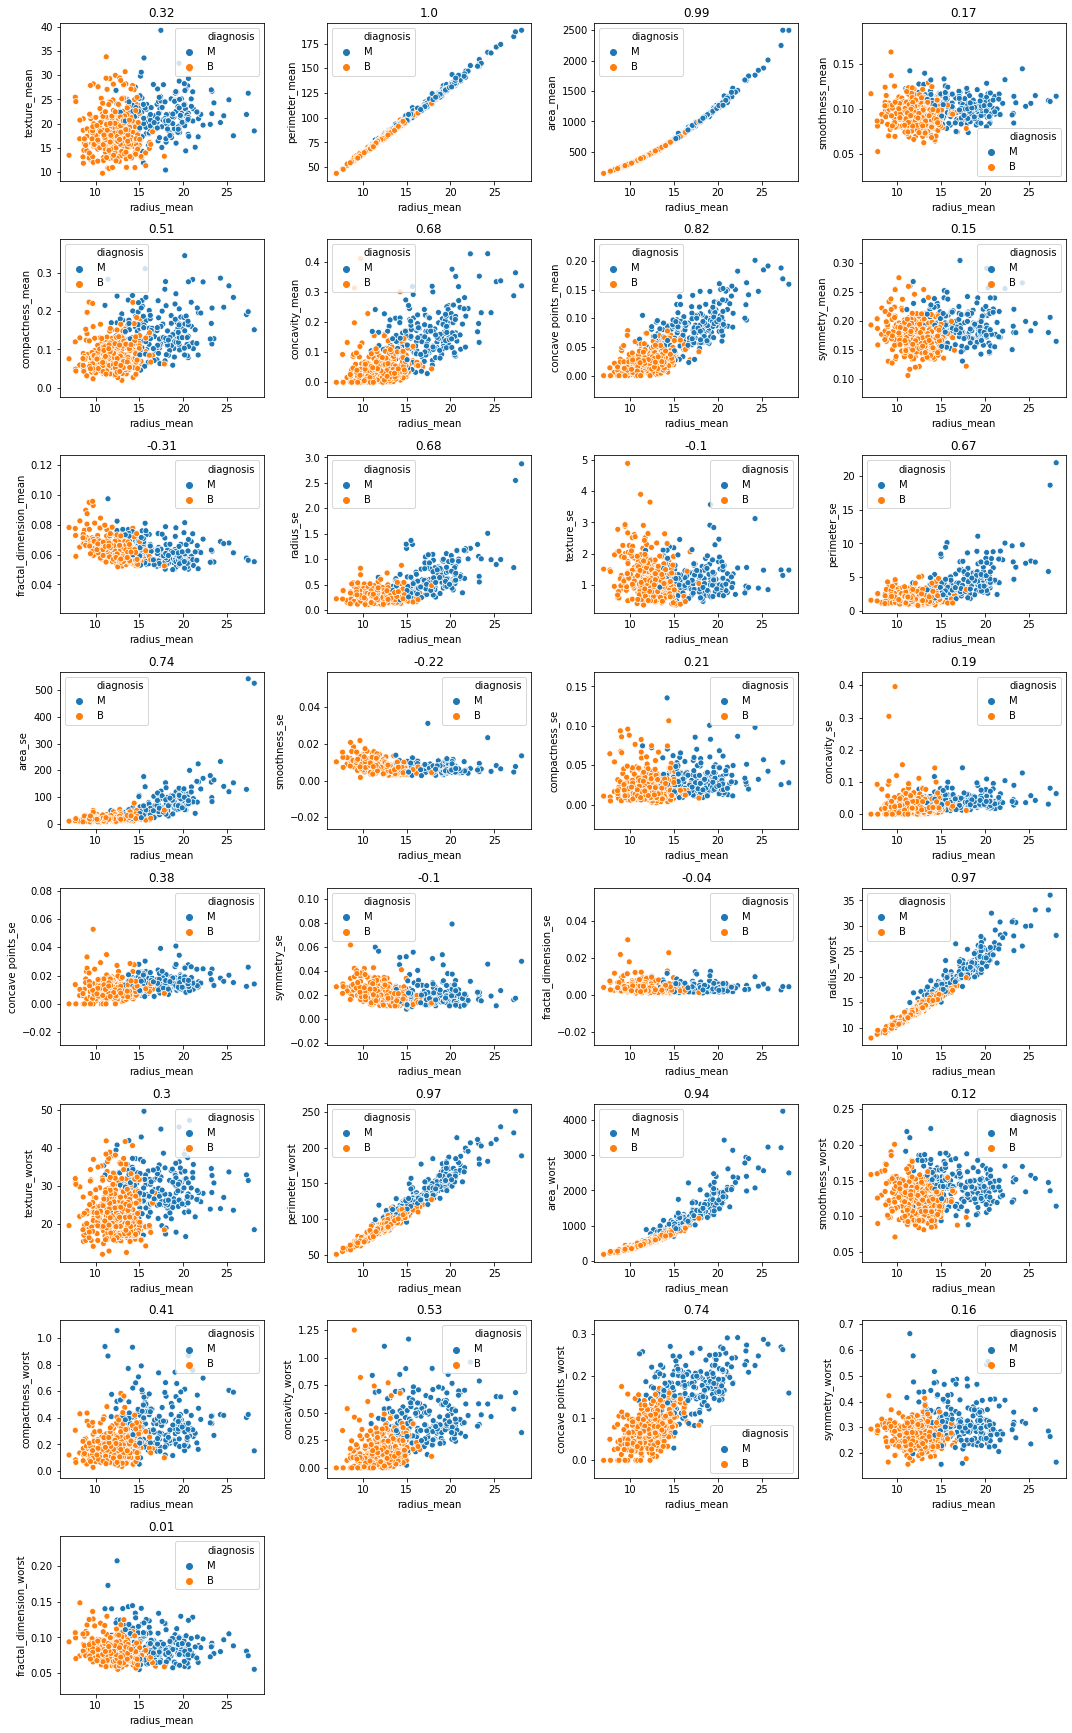

In [40]:
scatter_fea_corr_classif_targ(cancer, num.tolist(), 'diagnosis')

The graphs above shows:
1. The samples with different target labels are clustered in each graph, which indicates that some features play a significant role in classifying samples;
2. There is a small quantity of outlier samples, and removing outlier samples is not necessary;
3. Some features are highly correlated to each other, which has to be dealt with later.

In [41]:
mi = pd.Series(mutual_info_classif(cancer[num], cancer['diagnosis'], random_state = 42), index = num, name = 'score')
mi = mi.sort_values(ascending = False)
mi

perimeter_worst            0.471842
area_worst                 0.464313
radius_worst               0.451230
concave points_mean        0.438806
concave points_worst       0.436255
perimeter_mean             0.402361
concavity_mean             0.375447
radius_mean                0.362276
area_mean                  0.360023
area_se                    0.340759
concavity_worst            0.315259
perimeter_se               0.275614
radius_se                  0.249301
compactness_worst          0.225211
compactness_mean           0.213439
concave points_se          0.125415
texture_worst              0.120331
concavity_se               0.117440
texture_mean               0.096540
smoothness_worst           0.095697
symmetry_worst             0.095435
smoothness_mean            0.079740
compactness_se             0.073390
symmetry_mean              0.065721
fractal_dimension_worst    0.065041
fractal_dimension_se       0.039235
smoothness_se              0.015651
symmetry_se                0

The feature selection technique shows that 'perimeter_worst' is the most significant feature in predicting target. 
And the order in which the features are ranked by their significance descendingly is derived.

In [42]:
feat_ordered = mi.index

In [70]:
len(feat_ordered)

30

It is necessary to remove some features as there are 30 features in the dataset and some of them are highly correlated to eah other.

In [44]:
def get_feat_lin_inde(df, feature_ordered, threshold):
    i = 1
    feat_lin_inde = []
    feat_lin_inde.append(feature_ordered[0])

    while i <= (len(feature_ordered) - 1):
        feat_to_be_considered = feature_ordered[i]
        flag = True
        for feat in feat_lin_inde:
            if abs(df[feat_to_be_considered].corr(df[feat])) >= threshold:
                flag = False
                break
        if flag:
            feat_lin_inde.append(feat_to_be_considered)
        i += 1

    return feat_lin_inde

In [46]:
feat_lin_inde = get_feat_lin_inde(cancer, feat_ordered, 0.5)
feat_lin_inde

['perimeter_worst',
 'concave points_se',
 'texture_worst',
 'smoothness_worst',
 'symmetry_worst',
 'smoothness_se',
 'symmetry_se',
 'texture_se']

The eight features above were picked from the 'feat_ordered', and they do not have a heavily linear correlation to each other.

In [ ]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [47]:
get_mean_std(cancer[feat_lin_inde])

,mean,std
perimeter_worst,107.261213,33.602542
concave points_se,0.011796,0.006170
texture_worst,25.677223,6.146258
smoothness_worst,0.132369,0.022832
symmetry_worst,0.290076,0.061867
smoothness_se,0.007041,0.003003
symmetry_se,0.020542,0.008266
texture_se,1.216853,0.551648


The table above shows that the range is not similar among features, and 'scale' has to be done to the dataset.

In [52]:
X_scaled = pd.DataFrame(scale(cancer[feat_lin_inde]), columns = feat_lin_inde)

In [55]:
encoder = LabelEncoder()
y = encoder.fit_transform(cancer['diagnosis'])

In [18]:
lr = LogisticRegression(random_state = 42)

In [ ]:
def num_feat_perform(algorithm, feat_ordered, X, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')

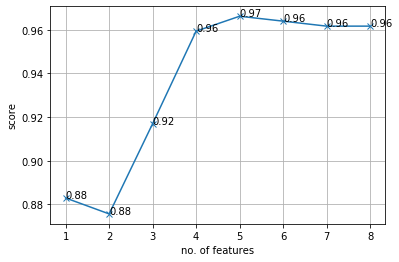

In [56]:
num_feat_perform(lr, feat_lin_inde, X_scaled, y, 'f1')
plt.show()

The graph above shows:
1. Only the first five featues have to be involved to achieve the best performance when 'LogisticRegression' is used;
2. Cross valuation score could go as high as 0.97 with performance being measured by 'f1'.

In [72]:
feat_lin_inde[0:5]

['perimeter_worst',
 'concave points_se',
 'texture_worst',
 'smoothness_worst',
 'symmetry_worst']

In [57]:
train_sizes = np.linspace(start = 10, stop = X_scaled.shape[0] * 0.8, num = 6, dtype = int)

In [66]:
def plot_learning_curve(train_scores, test_scores):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

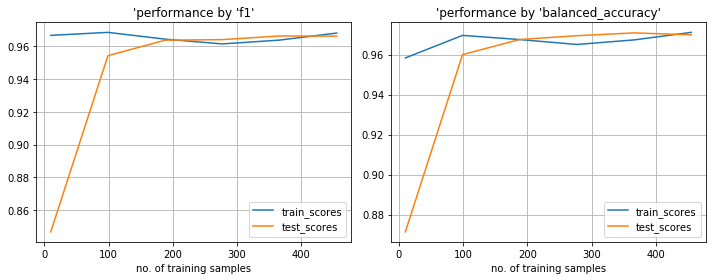

In [73]:
two_metric_graph(lr, X_scaled[feat_lin_inde[0:5]], y)

The graphs above shows that the training score and test score was able to converge within the current dataset, which means the model constructed is reliable with no serious overfitting.

In [76]:
feat_lin_inde[0:5]

['perimeter_worst',
 'concave points_se',
 'texture_worst',
 'smoothness_worst',
 'symmetry_worst']

In [75]:
lr.fit(X_scaled[feat_lin_inde[0:5]], y)
joblib.dump(lr, 'lr.joblib')

['lr.joblib']

Conclusion: The model was constructed with 'LogisticRegression' and five features, and it is reliable with no serious overfitting. Its score of performance measured by 'f1' or 'balanced accuracy' could go to 0.97.

The selected features are: 'perimeter_worst', 'concave points_se', 'texture_worst', 'smoothness_worst', 'symmetry_worst'